In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# models
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LassoCV, LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# data resampling
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import (
    GradientBoostingRegressor,
    RandomForestClassifier,
    RandomForestRegressor,
)

# feature selection
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import (
    RFE,
    SelectKBest,
    VarianceThreshold,
    mutual_info_classif,
)

# model evaluation
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    auc,
    confusion_matrix,
    f1_score,
    roc_curve,
)

# hyper parameter tuning
from sklearn.model_selection import GridSearchCV

# Data Loading and process
- load data and check pupulation size
- split data to train and test data

### Load data and check pupulation size
- df: original data
- df_rename: 'Bankrupt?' : 'target', features: Attr1~Attr95

In [56]:
# Read in dataset
df = pd.read_csv("data.csv")
df_rename = df.copy()
population_size = len(df)
# Rename columns
df.rename(columns={"Bankrupt?": "target"}, inplace=True)
index = 0
for col in df_rename.columns:
    if col == "Bankrupt?":
        df_rename.rename(columns={col: "target"}, inplace=True)
    else:
        df_rename.rename(columns={col: "Attr" + str(index)}, inplace=True)
    index += 1

# Checking data population
print("data shape:", df_rename.shape)
# Checking target incidence
print("\ndata incidence", df_rename.target.value_counts(normalize=True))


data shape: (6819, 96)

data incidence 0    0.967737
1    0.032263
Name: target, dtype: float64


$\implies$ 3% of target '1': imbalanced data</br>
$\implies$ 96 features: high-dimensional dataset


array([[<AxesSubplot:title={'center':'target'}>,
        <AxesSubplot:title={'center':'Attr1'}>,
        <AxesSubplot:title={'center':'Attr2'}>,
        <AxesSubplot:title={'center':'Attr3'}>,
        <AxesSubplot:title={'center':'Attr4'}>,
        <AxesSubplot:title={'center':'Attr5'}>,
        <AxesSubplot:title={'center':'Attr6'}>,
        <AxesSubplot:title={'center':'Attr7'}>,
        <AxesSubplot:title={'center':'Attr8'}>,
        <AxesSubplot:title={'center':'Attr9'}>],
       [<AxesSubplot:title={'center':'Attr10'}>,
        <AxesSubplot:title={'center':'Attr11'}>,
        <AxesSubplot:title={'center':'Attr12'}>,
        <AxesSubplot:title={'center':'Attr13'}>,
        <AxesSubplot:title={'center':'Attr14'}>,
        <AxesSubplot:title={'center':'Attr15'}>,
        <AxesSubplot:title={'center':'Attr16'}>,
        <AxesSubplot:title={'center':'Attr17'}>,
        <AxesSubplot:title={'center':'Attr18'}>,
        <AxesSubplot:title={'center':'Attr19'}>],
       [<AxesSubplot:title=

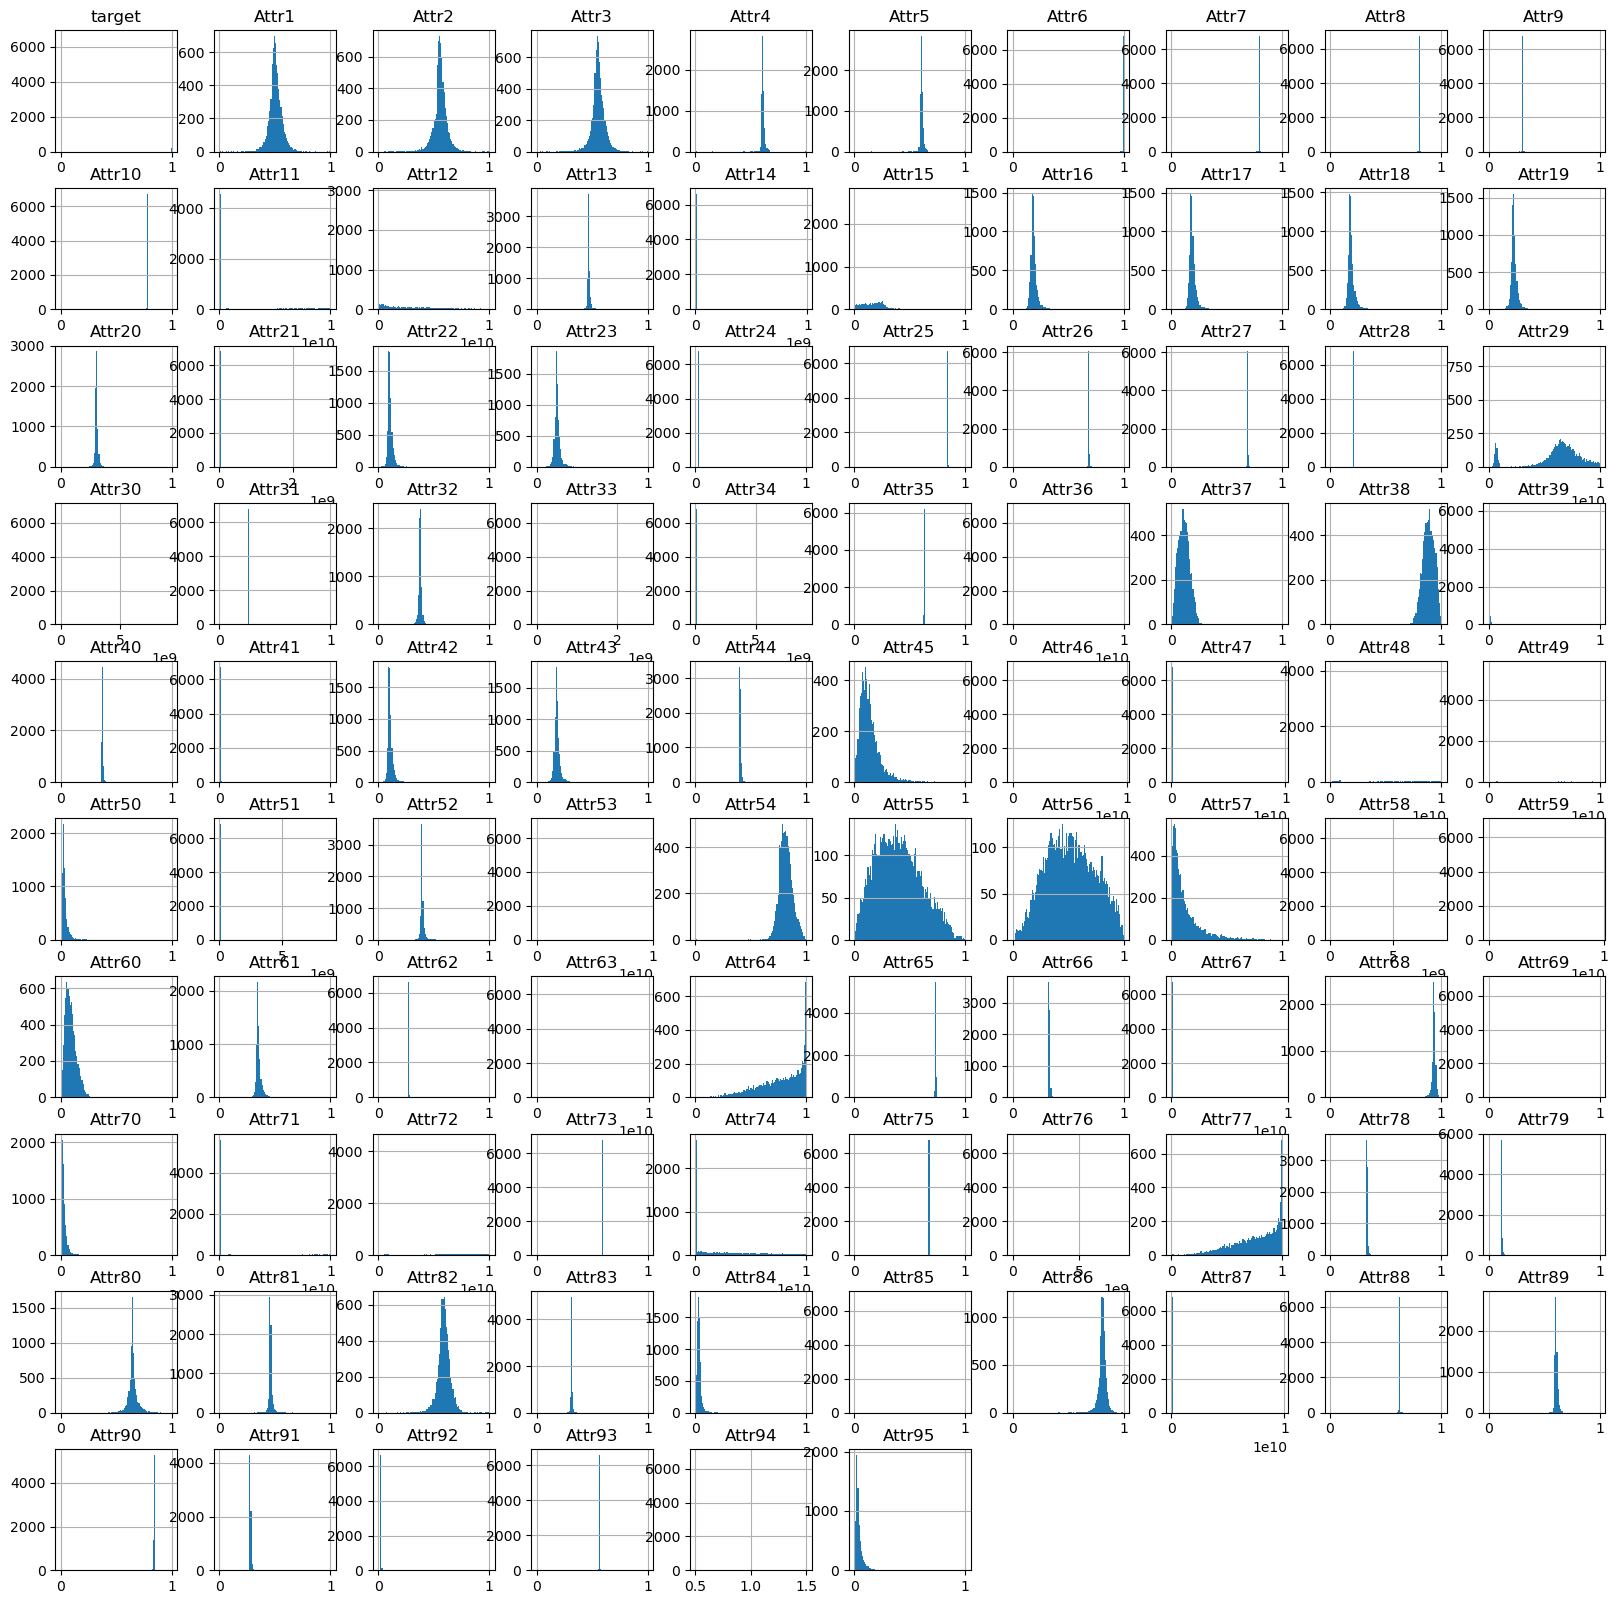

In [4]:
df_rename.hist(bins=100, figsize=(20, 20))

### Split data to train and test data
- X: all features data
- y: target data
- X_train, X_test, y_train, y_teat splited by 'train_test_split' with test-size 0.3

In [57]:
# Assign Data to X and y
X = df_rename.drop(columns="target")
y = df_rename.target

In [65]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0, stratify=y
)
print("X_train shape:", X_train.shape,
      "\nX_test shape:", X_test.shape,
      "\ny_train shape:", y_train.shape,
      "\ny_test shape:", y_test.shape,
     )

X_train shape: (4773, 95) 
X_test shape: (2046, 95) 
y_train shape: (4773,) 
y_test shape: (2046,)


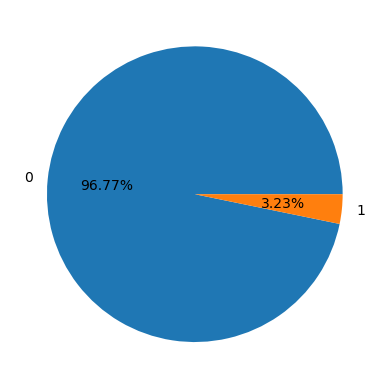

In [66]:
data = df["target"].value_counts()
plt.pie(data, autopct="%1.2f%%", labels=data.index)
plt.show()

## Resample Imbalanced data
- Using imblearn library </br>
  1. Undersampling with RandomForest: </br>This technique eliminates or deletes the data points of the majority class to make an equal ratio of major and minor classes.There is a various method for undersampling like Tomek’s links, EditedNearestNeighbours, CondensedNearestNeighbour, InstanceHardnessThreshold, etc.
  2. Oversampling: </br>This technique redistributes randomly the minority class data points to increase the ratio in the dataset.It duplicates the existing data points of minority class and equalizes the ratio of majority and minority class.
  3. SMOTE (Synthetic Minority Oversampling Technique):</br>SMOTE selects the data points of the minority class in feature space to draw a line between those points and generate new points along with the line. Thus this technique synthesizes new data points for minority class and oversample that class.</br>This is the most effective method for oversampling.

In [67]:
# Find the best resampled dataset
models = [RandomForestClassifier(), LogisticRegression(solver="liblinear"), KNeighborsClassifier(), DecisionTreeClassifier()]
models_name = ["RandomForestClassifier", "LogisticRegression", "KNeighborsClassifier", "DecisionTreeClassifier"]
# note: Logistic regression failed to converge in most cases with lbfgs algorithm, so we change to liblinear

# claim resample constants
C_ORIGINAL = "Original"
C_UNDERSAMPLING = "UnderSampling"
C_OVERSAMPLING = "OverSampling"
C_SMOTE = "SMOTE"

# claim feature selection constants
C_TARGETHIGHCORR = "TargetHighCorr"
C_REMOVE5VIF = "remove5VIF with targetHighCorr"
C_MODELREDUCEFEATURE = "ModelReduceFeature"
C_KBESTMUTUALINFO = "kBestMutualInfo"
C_OPT = "tuneHyperparameter"

# model data init
data_names = [C_ORIGINAL, C_UNDERSAMPLING, C_OVERSAMPLING, C_SMOTE, C_OPT]
models_f1Score = pd.DataFrame(columns=models_name, index=data_names)
models_accurracy = pd.DataFrame(columns=models_name, index=data_names)

# for later combined charts
auc_rocs = {}

In [68]:
def print_roc_auc_curve_cm(y_test, y_pre, probabilities, md_name, data_name):
    # select the probabilities for label 1.0
    y_proba = probabilities[:, 1]

    # calculate false positive rate and true positive rate at different thresholds
    false_positive_rate, true_positive_rate, thresholds = roc_curve(
        y_test, y_proba, pos_label=1
    )
    
    # calculate AUC
    roc_auc = auc(false_positive_rate, true_positive_rate)

    # save combined data to global variables
    if not auc_rocs or data_name not in auc_rocs:
        auc_rocs[data_name] = []
    auc_rocs[data_name].append({"model_name": md_name, "auc": roc_auc, "fpr": false_positive_rate, "tpr": true_positive_rate})
    
    # create plot
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False, figsize=(12, 4), dpi=72)
    plot_title = (
            md_name
            + "("
            + data_name
            + ") F1s:"
            + format(models_f1Score[md_name][data_name], ".2f")
        )

    ax1.set_title(plot_title)
    # plot the false positive rate on the x axis and the true positive rate on the y axis
    roc_plot = ax1.plot(
        false_positive_rate, true_positive_rate, label="AUC = {:0.2f}".format(roc_auc)
    )
    ax1.legend(loc=0)
    ax1.plot([0, 1], [0, 1], ls="--")
    ax1.set_ylabel("True Positive Rate")
    ax1.set_xlabel("False Positive Rate")

    # print confusion matrix
    c_matrix = confusion_matrix(y_test, y_pre)
    ax2.set_title(plot_title)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=c_matrix, display_labels=["Not bankrupt", "Is bankrupt"]
    )
    disp.plot(ax=ax2)
    fig

In [69]:
def get_f1score_accuracy(md_name, y_test, y_pre):
    return f1_score(y_test, y_pre, average="macro"), accuracy_score(y_test, y_pre)

In [70]:
def testModels(X_train, y_train, X_test, y_test, data_name, needPrint):
    # init model f1 and accuracy
    models_f1Score.loc[data_name] = np.zeros(len(models))
    models_accurracy.loc[data_name] = np.zeros(len(models))
    
    for md_name, md in zip(models_name, models):
        # predict
        md.fit(X_train, y_train)
        y_pre = md.predict(X_test)
        probabilities = md.predict_proba(X_test)

        # get f1 score and accuracy
        models_f1Score[md_name][data_name], models_accurracy[md_name][data_name] = get_f1score_accuracy(md_name, y_test, y_pre)
    
        if needPrint:
            # print roc curve and confusion matrix
            print_roc_auc_curve_cm(y_test, y_pre, probabilities, md_name, data_name)
        #overfitting check
        train_pre = md.predict(X_train)
        train_acc = accuracy_score(y_train, train_pre)
        print(md_name+": train accurancy-",format(train_acc,".2f"),
              "and test accruancy-",format(models_accurracy[md_name][data_name],".2f")
             )    
        

RandomForestClassifier: train accurancy- 1.00 and test accruancy- 0.97
LogisticRegression: train accurancy- 0.97 and test accruancy- 0.97
KNeighborsClassifier: train accurancy- 0.97 and test accruancy- 0.97
DecisionTreeClassifier: train accurancy- 1.00 and test accruancy- 0.95


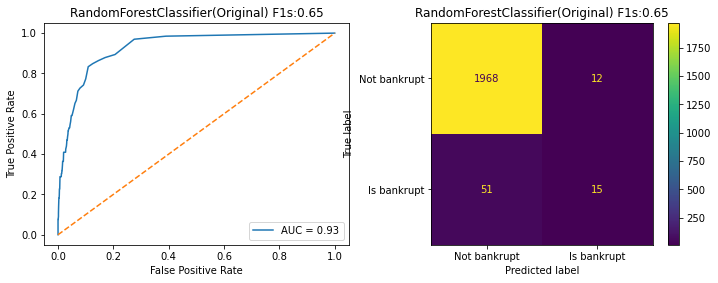

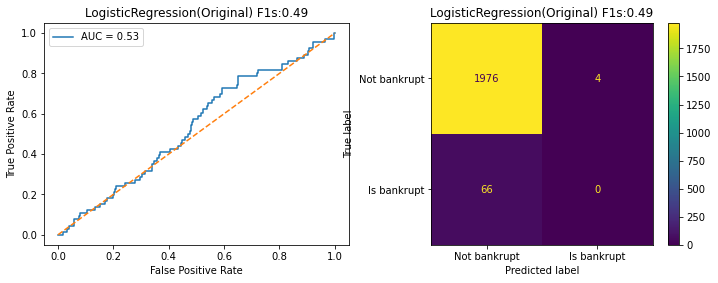

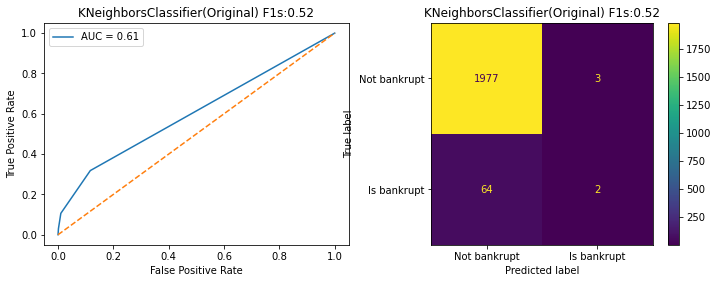

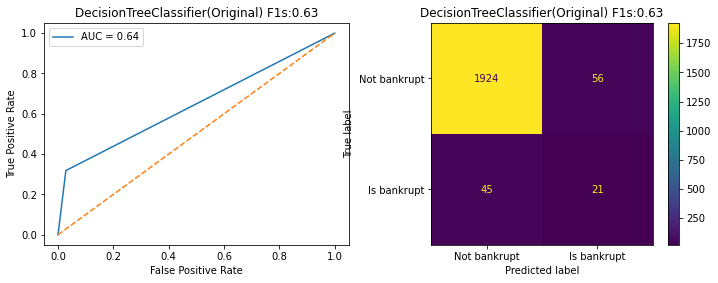

In [71]:
testModels(X_train, y_train, X_test, y_test, C_ORIGINAL, True)

X_underSampling's shape: (308, 95) y_underSampling's shape: (308,)
y_underSampling:
 0    0.5
1    0.5
Name: target, dtype: float64
RandomForestClassifier: train accurancy- 1.00 and test accruancy- 0.85
LogisticRegression: train accurancy- 0.61 and test accruancy- 0.69
KNeighborsClassifier: train accurancy- 0.76 and test accruancy- 0.57
DecisionTreeClassifier: train accurancy- 1.00 and test accruancy- 0.79


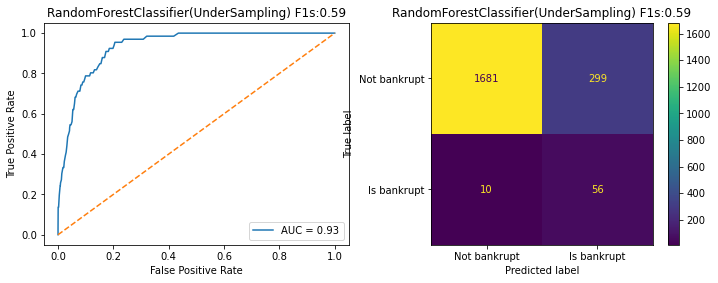

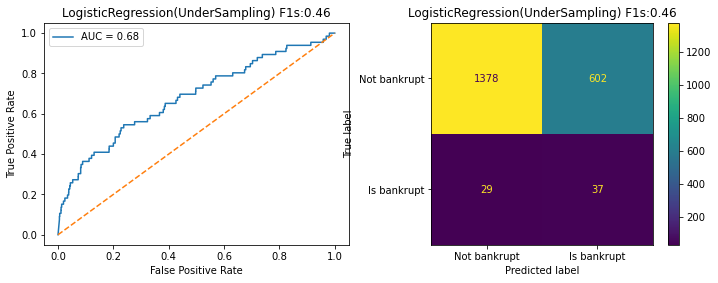

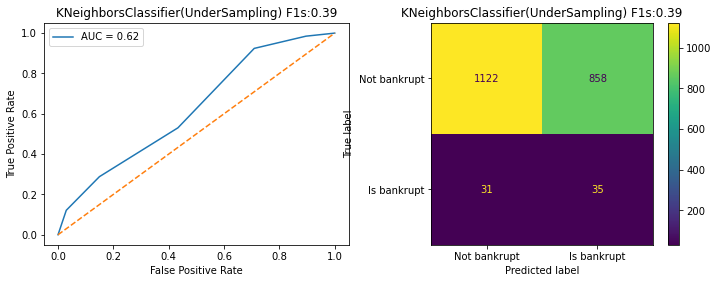

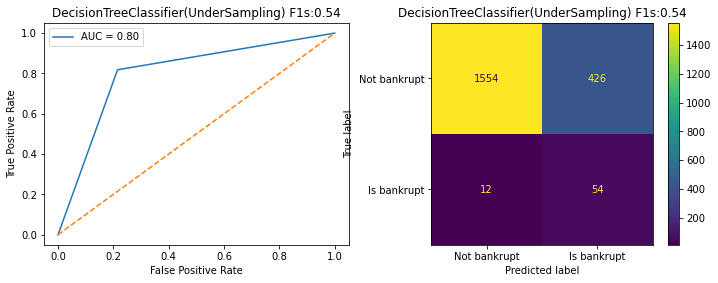

In [72]:
# Undersampling
rus = RandomUnderSampler(random_state=0)
X_underSampling, y_underSampling = rus.fit_resample(X_train, y_train)
print(
    "X_underSampling's shape:",
    X_underSampling.shape,
    "y_underSampling's shape:",
    y_underSampling.shape,
)
print("y_underSampling:\n", y_underSampling.value_counts(normalize=True))
testModels(X_underSampling, y_underSampling, X_test, y_test, C_UNDERSAMPLING, True)


### Oversampling

X_overSampling's shape: (9238, 95) y_overSampling's shape: (9238,)
y_overSampling:
 0    0.5
1    0.5
Name: target, dtype: float64
RandomForestClassifier: train accurancy- 1.00 and test accruancy- 0.97
LogisticRegression: train accurancy- 0.61 and test accruancy- 0.74
KNeighborsClassifier: train accurancy- 0.97 and test accruancy- 0.91
DecisionTreeClassifier: train accurancy- 1.00 and test accruancy- 0.95


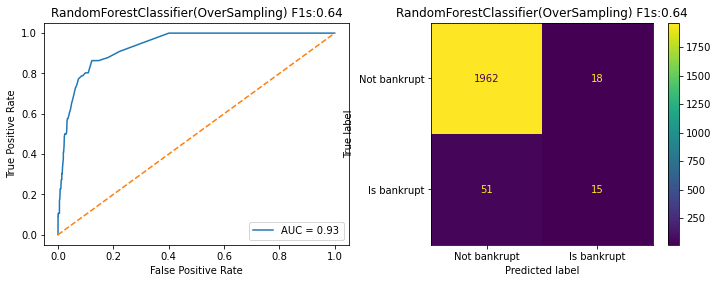

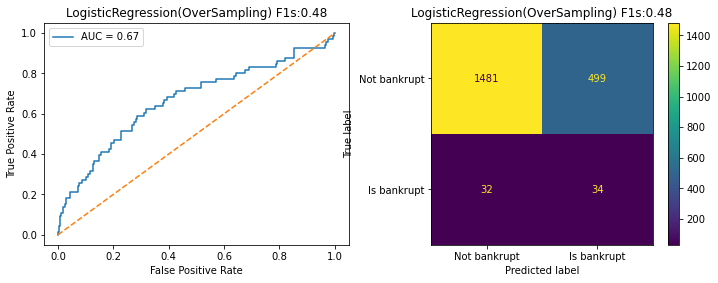

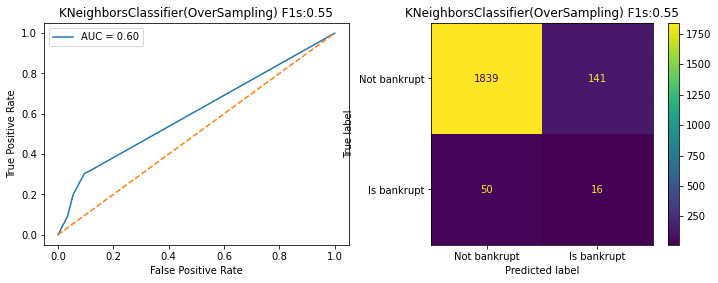

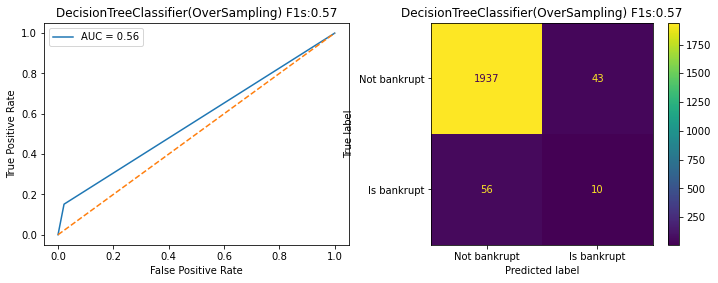

In [73]:
# Oversampling
ros = RandomOverSampler(random_state=0)
X_overSampling, y_overSampling = ros.fit_resample(X_train, y_train)
print(
    "X_overSampling's shape:",
    X_overSampling.shape,
    "y_overSampling's shape:",
    y_overSampling.shape,
)
print("y_overSampling:\n", y_overSampling.value_counts(normalize=True))
testModels(X_overSampling, y_overSampling, X_test, y_test, C_OVERSAMPLING, True)

### SMOTE

X_smote's shape: (9238, 95) y_smote's shape: (9238,)
y_smote:
 0    0.5
1    0.5
Name: target, dtype: float64
RandomForestClassifier: train accurancy- 1.00 and test accruancy- 0.95
LogisticRegression: train accurancy- 0.58 and test accruancy- 0.75
KNeighborsClassifier: train accurancy- 0.95 and test accruancy- 0.85
DecisionTreeClassifier: train accurancy- 1.00 and test accruancy- 0.93


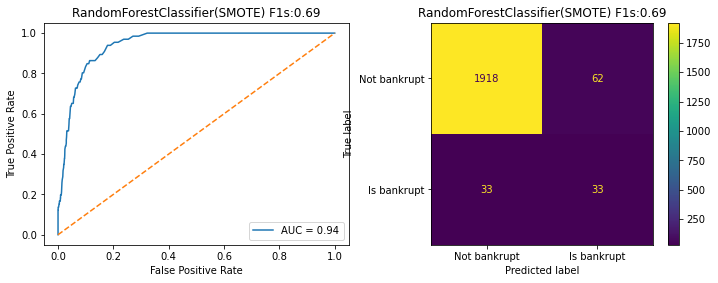

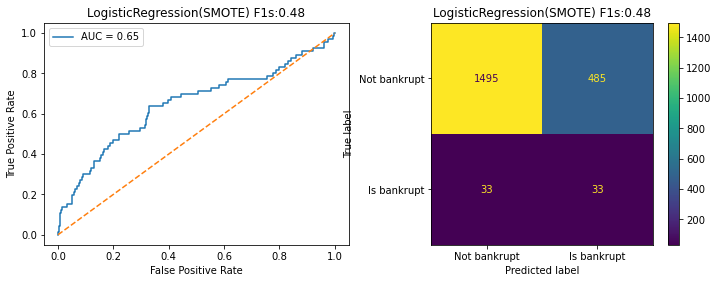

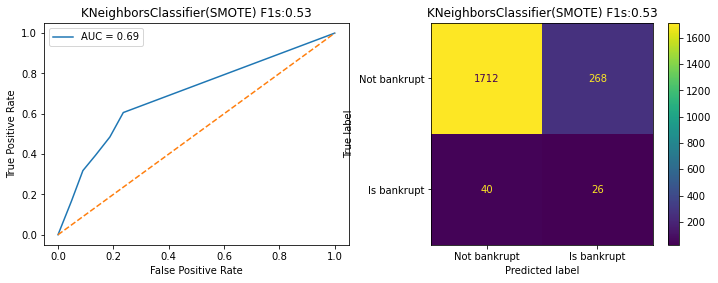

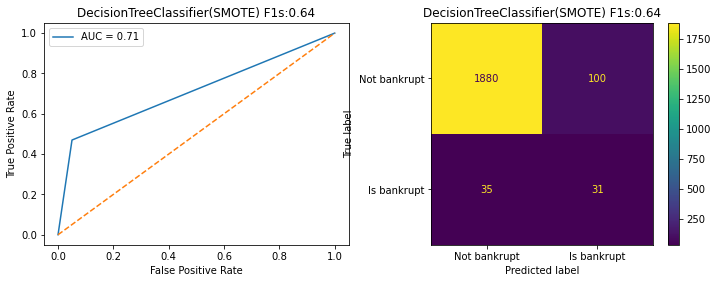

In [74]:
# SMOTE
sm = SMOTE(random_state=0)
X_smote, y_smote = sm.fit_resample(X_train, y_train)
print("X_smote's shape:", X_smote.shape, "y_smote's shape:", y_smote.shape)
print("y_smote:\n", y_smote.value_counts(normalize=True))
testModels(X_smote, y_smote, X_test, y_test, C_SMOTE, True)

In [ ]:
check_overfitting(X_smote, y_smote, X_test, y_test, 30)

In [113]:
models_f1Score

,RandomForestClassifier,LogisticRegression,KNeighborsClassifier,DecisionTreeClassifier
Original,0.653413,0.491298,0.519838,0.634065
UnderSampling,0.59093,0.459332,0.39462,0.537141
OverSampling,0.642875,0.480752,0.547065,0.571575
SMOTE,0.692886,0.482676,0.530957,0.64003
tuneHyperparameter,NaN,NaN,NaN,NaN
TargetHighCorr,0.661508,0.617032,0.601723,0.599879
remove5VIF with targetHighCorr,0.627633,0.590727,0.575114,0.580006
ModelReduceFeature,0.672992,0.499747,0.471968,0.618517
kBestMutualInfo,0.687877,0.467298,0.509158,0.613498


In [121]:
models_accurracy

,RandomForestClassifier,LogisticRegression,KNeighborsClassifier,DecisionTreeClassifier
Original,0.969208,0.965787,0.967253,0.950635
UnderSampling,0.848974,0.691593,0.565494,0.785924
OverSampling,0.966276,0.740469,0.906647,0.951613
SMOTE,0.953568,0.746823,0.849462,0.934018
tuneHyperparameter,NaN,NaN,NaN,NaN
TargetHighCorr,0.936461,0.875855,0.880254,0.915445
remove5VIF with targetHighCorr,0.92131,0.841642,0.855816,0.891496
ModelReduceFeature,0.938905,0.863636,0.711144,0.9174
kBestMutualInfo,0.949169,0.772239,0.805963,0.924731


# According to the above result, SMOTOE has best accuracy, so we will continue to select features using oversampling data.

In [95]:
X_resample = X_smote.copy()
y_resample = y_smote.copy()
X_resample.shape, y_resample.shape

((9238, 95), (9238,))

In [96]:
X_resample.head()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,...,Attr86,Attr87,Attr88,Attr89,Attr90,Attr91,Attr92,Attr93,Attr94,Attr95
0,0.577634,0.650131,0.640987,0.613111,0.613111,0.999168,0.797648,0.809559,0.303561,0.781834,...,0.846247,0.001604,0.625023,0.613105,0.845538,0.283816,0.026811,0.565250,1,0.020829
1,0.507093,0.565907,0.553188,0.601551,0.601551,0.999023,0.797465,0.809365,0.303544,0.781620,...,0.813017,0.001934,0.623323,0.601547,0.841623,0.281430,0.027045,0.566135,1,0.024576
2,0.489056,0.521969,0.543926,0.596340,0.596340,0.998941,0.797357,0.809285,0.303526,0.781539,...,0.789707,0.009648,0.624593,0.596341,0.839563,0.279088,0.026674,0.564527,1,0.032201
3,0.555648,0.599815,0.594357,0.604217,0.604217,0.999089,0.797528,0.809411,0.303516,0.781677,...,0.830968,0.000908,0.624633,0.604219,0.842402,0.277784,0.026817,0.565280,1,0.041431
4,0.449374,0.515591,0.500616,0.596499,0.596499,0.998937,0.797356,0.809285,0.303533,0.781539,...,0.777253,0.001069,0.623805,0.596497,0.838273,0.281692,0.026386,0.562021,1,0.024040


# Feature Selectioon
- Removing highly correlated features
- Removing highly  VIF-scored features
- Selecting for Model Accuracy
- Selecting by Mutual Information

# Removing highly hightly VIF-scored features

In [97]:
# caculate the correlation between target and each feature and take the absolute value
corr_df = df_rename.corr()["target"].abs()
# list of features which have at least 9% (the mean of total correlations) correlation to the target
features = corr_df[corr_df <= 0.09].index.to_list()[1:]
# drop the features in the features list
train_targetHighCorr = X_resample.drop(features, axis=1)
test_targetHighCorr = X_test.drop(features, axis=1)

In [98]:
corr_df.mean()

0.09116505557155975

In [99]:
train_targetHighCorr.shape

(9238, 36)

RandomForestClassifier: train accurancy- 1.00 and test accruancy- 0.94
LogisticRegression: train accurancy- 0.89 and test accruancy- 0.88
KNeighborsClassifier: train accurancy- 0.96 and test accruancy- 0.88
DecisionTreeClassifier: train accurancy- 1.00 and test accruancy- 0.92


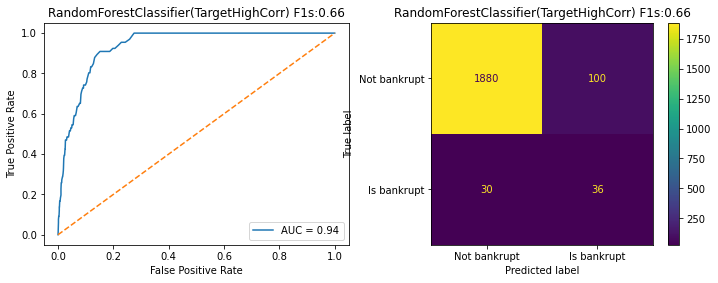

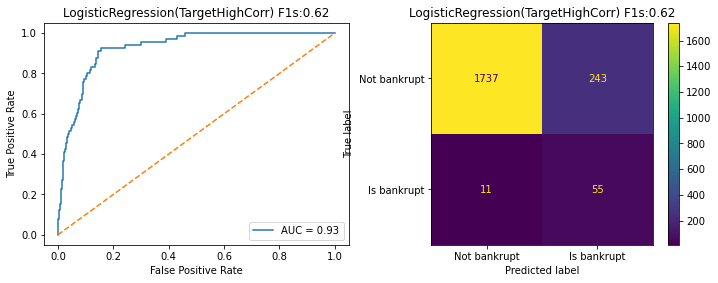

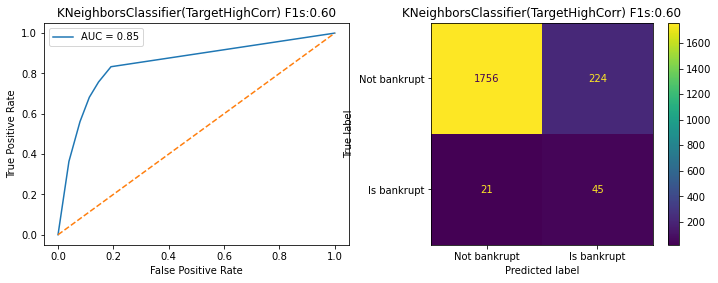

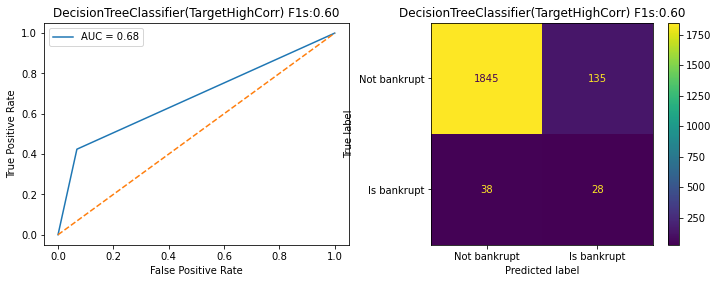

In [100]:
testModels(train_targetHighCorr, y_resample, test_targetHighCorr, y_test, C_TARGETHIGHCORR, True)

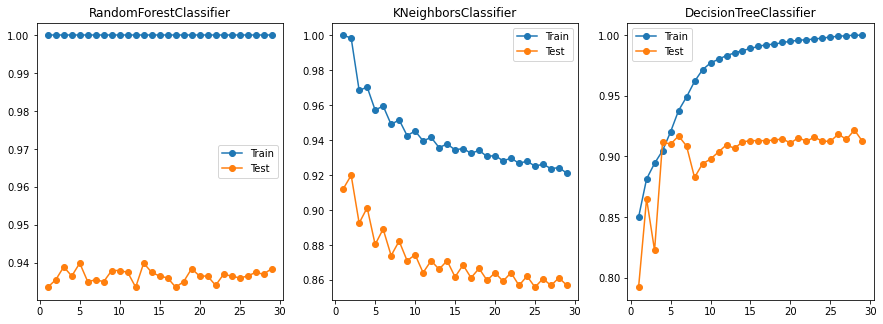

In [119]:
check_overfitting(train_targetHighCorr, y_resample, test_targetHighCorr, y_test, 30)

In [101]:
def drop_vif(df, vifIndex):
    vif, tolerance = {}, {}
    # all the features that you want to examine
    for feature in df.columns:
        # extract all the other features you will regress against
        X = [f for f in df.columns if f != feature]
        X, y = df[X], df[feature]
        # extract r-squared from the fit
        r2 = LinearRegression().fit(X, y).score(X, y)
        # calculate tolerance
        tolerance[feature] = 1 - r2
        # calculate VIF
        if tolerance[feature] == 0:
            vif[feature] = 0
            continue
        vif[feature] = 1 / (tolerance[feature])
    # return drop features of VIF > vifIndex
    to_drop = [f for f in df.columns if vif[f] > vifIndex]
    return to_drop

In [102]:
# Drop the features whose vif is greater than 5 after targetHighCorr
train_remove5VIF = train_targetHighCorr.drop(drop_vif(train_targetHighCorr, 5), axis=1)
train_remove5VIF.shape
test_remove5VIF = test_targetHighCorr.drop(drop_vif(train_targetHighCorr, 5), axis=1)

RandomForestClassifier: train accurancy- 1.00 and test accruancy- 0.92
LogisticRegression: train accurancy- 0.84 and test accruancy- 0.84
KNeighborsClassifier: train accurancy- 0.95 and test accruancy- 0.86
DecisionTreeClassifier: train accurancy- 1.00 and test accruancy- 0.89


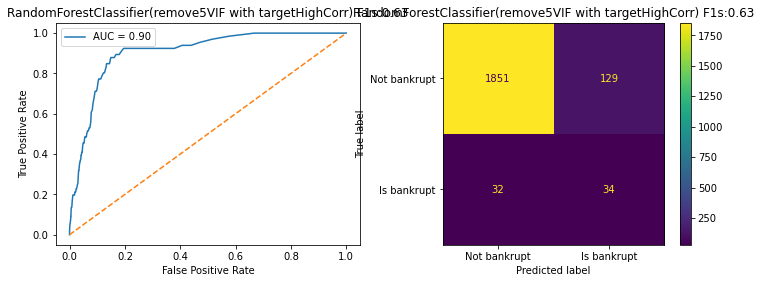

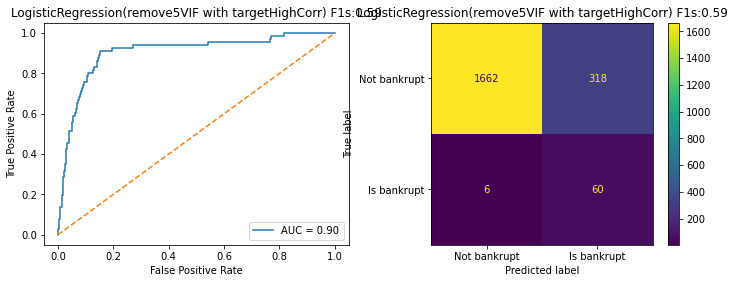

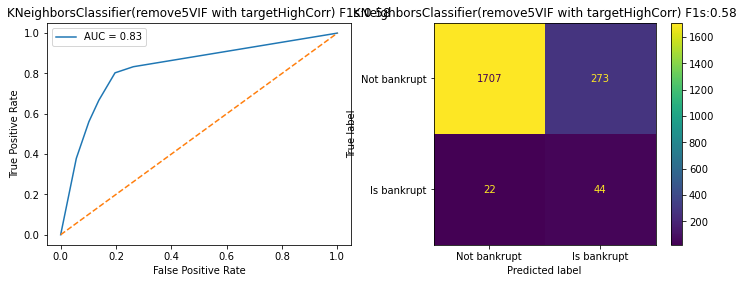

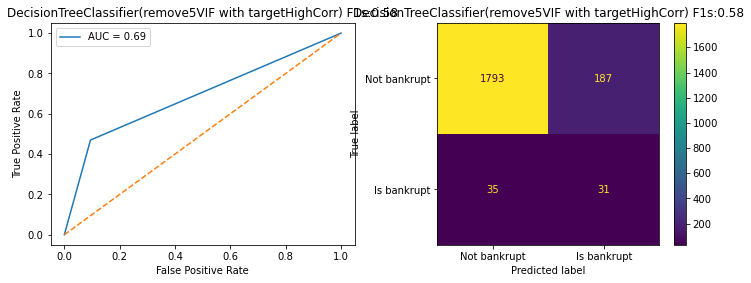

In [103]:
testModels(train_remove5VIF, y_resample, test_remove5VIF, y_test, C_REMOVE5VIF, True)

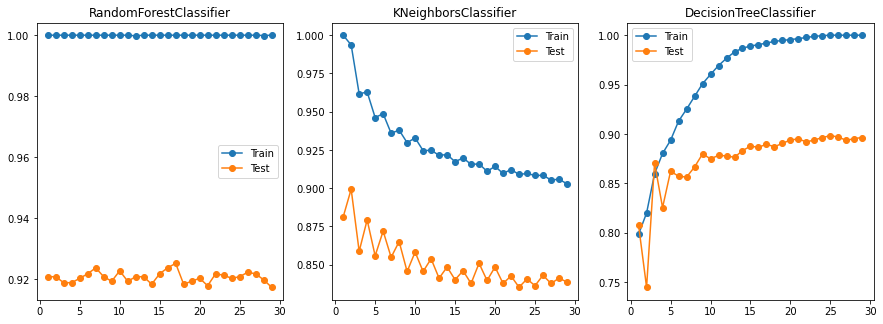

In [120]:
check_overfitting(train_remove5VIF, y_resample, test_remove5VIF, y_test, 30)

### Selecting for Model Accuracy
1. LassoCV
2. GradientBoostingRegressor
3. RandomForestRegressor

we test three regression's accuracy to decide which features to select

## 1. Using LassoCV() regressor which tunes the regularization strength(alpha) using cross validation

In [104]:
# 1. LassoCV
# create and fit the LassoCV model on the training set
lcv = LassoCV()
lcv.fit(X_resample, y_resample)
optimal_alpha = float("{:.3f}".format(lcv.alpha_))
print(f"Optimal alpha = {optimal_alpha}")

# calculate R squared on the test set
r_squared = lcv.score(X_test, y_test)
print(f"The model explains {r_squared:.1%} of the test set variance")

# create a mask for coefficients not equal to zero
lcv_mask = lcv.coef_ != 0
print(f"The LassoCV() model select {sum(lcv_mask)} features out of {len(lcv_mask)} selected")


Optimal alpha = 167424.766
The model explains -671.4% of the test set variance
The LassoCV() model select 22 features out of 95 selected


## 2. Using Recursive Feature Eliminator (RFE) on a GradientBoostingRegressor

In [105]:
# 2. GradientBoostingRegressor
# select 10 features with RFE and drop 19 features on each step
rfe_gb = RFE(
    estimator=GradientBoostingRegressor(), n_features_to_select=10, step=19, verbose=1
)
rfe_gb.fit(X_resample, y_resample)

# calculate the R squared on the test set
r_squared = rfe_gb.score(X_test, y_test)
print(f"The model can explain {r_squared:.1%} of the variance in the test set")

# assign the support array to gb_mask
gb_mask = rfe_gb.support_

Fitting estimator with 95 features.
Fitting estimator with 76 features.
Fitting estimator with 57 features.
Fitting estimator with 38 features.
Fitting estimator with 19 features.
The model can explain -125.4% of the variance in the test set


## 3. Using RFE on a RandomForestRegressor

In [106]:
# 3. RandomForestRegressor
# select 10 features with RFE on a RandomForestRegressor, drop 19 feature on each step
rfe_rf = RFE(
    estimator=RandomForestRegressor(), n_features_to_select=10, step=19, verbose=1
)
rfe_rf.fit(X_resample, y_resample)

# calculate the R squared on the test set
r_squared = rfe_rf.score(X_test, y_test)
print(f"The model can explain {r_squared:.1%} of the variance in the test set")

# assign the support array to rf_mask
rf_mask = rfe_rf.support_

Fitting estimator with 95 features.
Fitting estimator with 76 features.
Fitting estimator with 57 features.
Fitting estimator with 38 features.
Fitting estimator with 19 features.
The model can explain -45.7% of the variance in the test set


In [107]:
# sum the votes of the three models
votes = np.sum([lcv_mask, gb_mask, rf_mask], axis=0)
print("votes:", votes) # 0: not helpful, 1: only helpful for 1 model ... 3: helpful for all models

# create a mask for features selected by at least 2 model
meta_mask = votes >= 2

# apply the dimensionality reduction on X
train_modelReduceFeature = X_resample.loc[:, meta_mask]
train_modelReduceFeature.shape
test_modelReduceFeature = X_test.loc[:, meta_mask]

votes: [0 0 0 0 0 0 0 0 2 2 1 1 0 3 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 2 1 3 0
 0 0 2 0 0 0 0 0 1 3 1 1 0 1 0 1 0 0 0 0 1 1 0 0 0 1 0 0 0 1 0 0 0 2 1 0 3
 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 2 0 0 0 0 0]


RandomForestClassifier: train accurancy- 1.00 and test accruancy- 0.94
LogisticRegression: train accurancy- 0.52 and test accruancy- 0.86
KNeighborsClassifier: train accurancy- 0.83 and test accruancy- 0.71
DecisionTreeClassifier: train accurancy- 1.00 and test accruancy- 0.92


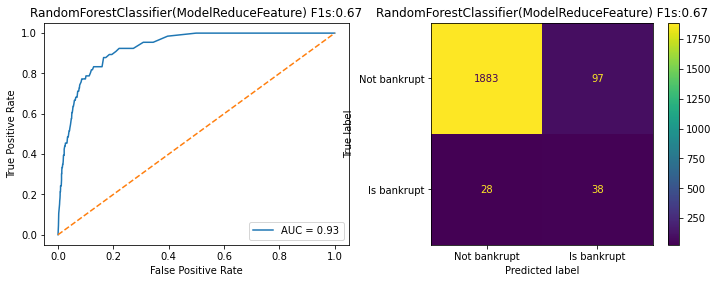

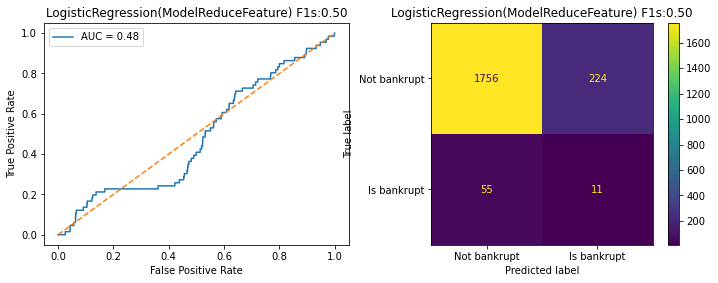

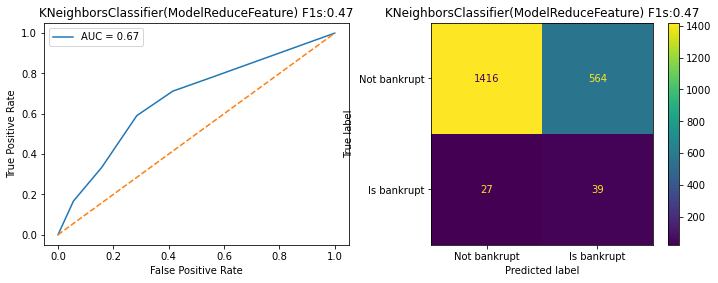

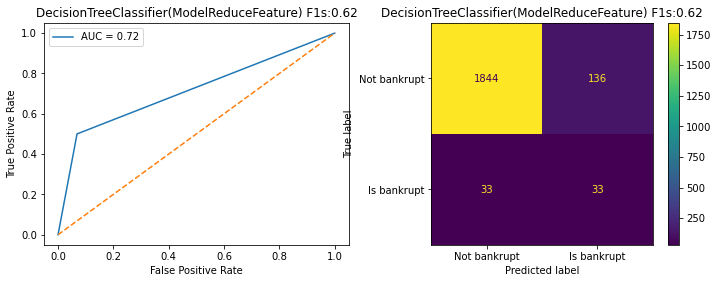

In [108]:
testModels(train_modelReduceFeature, y_resample, test_modelReduceFeature, y_test, C_MODELREDUCEFEATURE, True)

### Selecting by Mutual Infromation

Text(0, 0.5, 'Mutual Information')

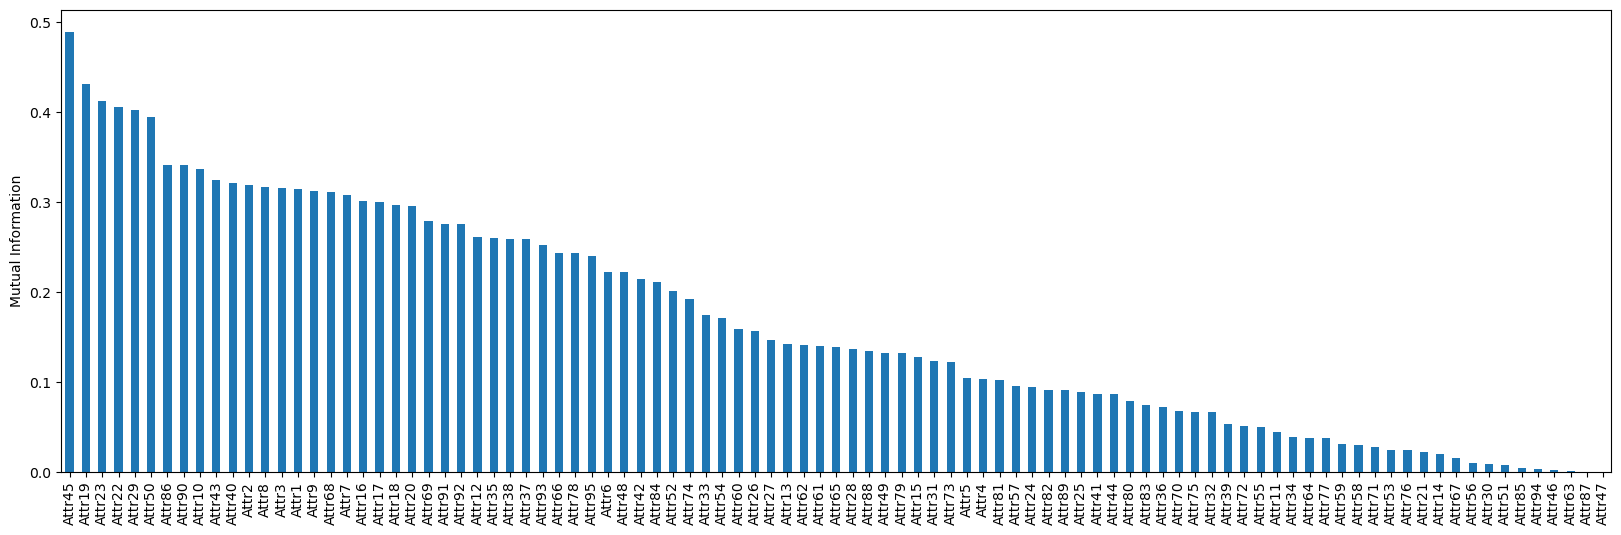

In [109]:
# the less mi value, the less information we can get from
mi = mutual_info_classif(X_resample, y_resample)
miseries = pd.Series(mi)
miseries.index = X_resample.columns
miseries.sort_values(ascending=False).plot.bar(figsize=(20, 6))
plt.ylabel("Mutual Information")


RandomForestClassifier: train accurancy- 1.00 and test accruancy- 0.95
LogisticRegression: train accurancy- 0.49 and test accruancy- 0.77
KNeighborsClassifier: train accurancy- 0.91 and test accruancy- 0.81
DecisionTreeClassifier: train accurancy- 1.00 and test accruancy- 0.92


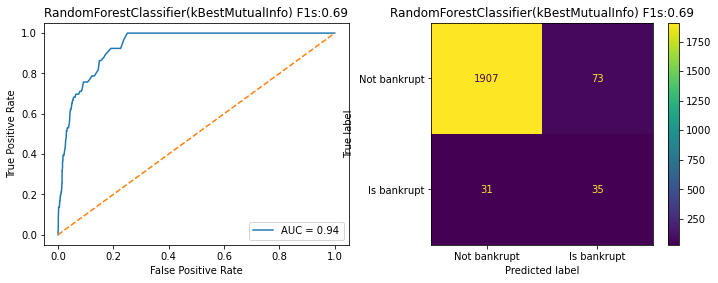

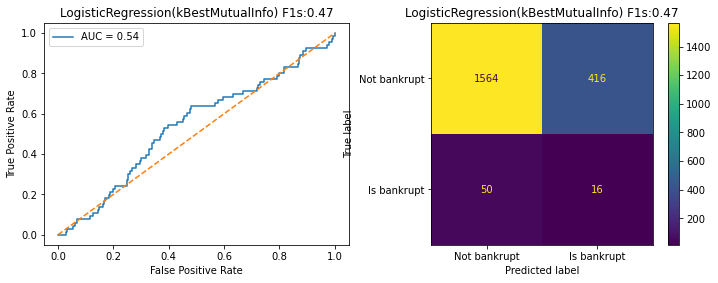

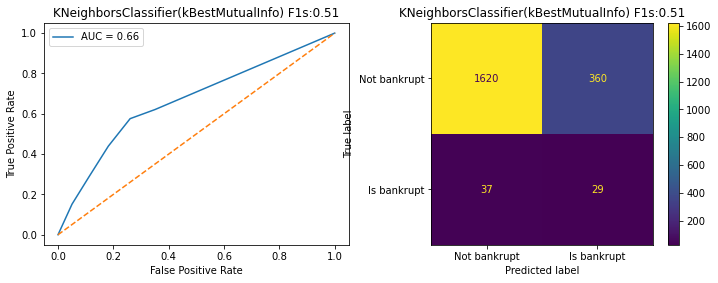

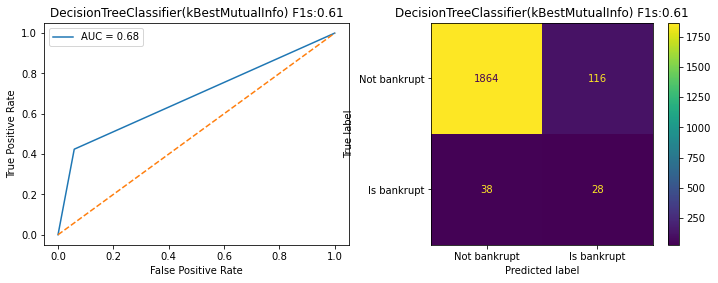

In [110]:
k_best = SelectKBest(mutual_info_classif, k=41).fit(X_resample, y_resample)
X_train_kBest = k_best.transform(X_resample)
X_test_kBest = k_best.transform(X_test)
testModels(X_train_kBest, y_resample, X_test_kBest, y_test, C_KBESTMUTUALINFO, True)

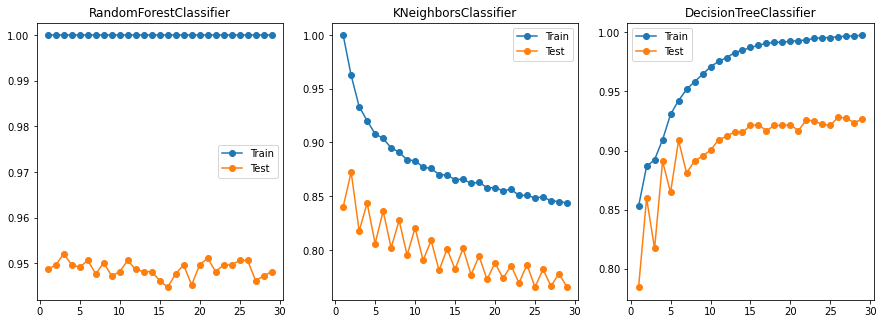

In [118]:
check_overfitting(X_train_kBest, y_resample, X_test_kBest, y_test , 30)

In [115]:
models_f1Score

,RandomForestClassifier,LogisticRegression,KNeighborsClassifier,DecisionTreeClassifier
Original,0.653413,0.491298,0.519838,0.634065
UnderSampling,0.59093,0.459332,0.39462,0.537141
OverSampling,0.642875,0.480752,0.547065,0.571575
SMOTE,0.692886,0.482676,0.530957,0.64003
tuneHyperparameter,NaN,NaN,NaN,NaN
TargetHighCorr,0.661508,0.617032,0.601723,0.599879
remove5VIF with targetHighCorr,0.627633,0.590727,0.575114,0.580006
ModelReduceFeature,0.672992,0.499747,0.471968,0.618517
kBestMutualInfo,0.687877,0.467298,0.509158,0.613498


In [116]:
models_accurracy

,RandomForestClassifier,LogisticRegression,KNeighborsClassifier,DecisionTreeClassifier
Original,0.969208,0.965787,0.967253,0.950635
UnderSampling,0.848974,0.691593,0.565494,0.785924
OverSampling,0.966276,0.740469,0.906647,0.951613
SMOTE,0.953568,0.746823,0.849462,0.934018
tuneHyperparameter,NaN,NaN,NaN,NaN
TargetHighCorr,0.936461,0.875855,0.880254,0.915445
remove5VIF with targetHighCorr,0.92131,0.841642,0.855816,0.891496
ModelReduceFeature,0.938905,0.863636,0.711144,0.9174
kBestMutualInfo,0.949169,0.772239,0.805963,0.924731


# Check overfitting by learning depths
- RandomForestClassifier
- KNeighborsClassifier 
- Decision Tree </br>
Note that the Logistic Regression accurancy comparasion between train and test data does not have overfitting problem. </br>
However, the accurancy comparasion of other three models above is hard to indentify overfitting. </br>
Therefore, we check overfitting problem for these three models by learning depths </br>

In [117]:
def check_overfitting(X_train, y_train, X_test, y_test, max_depth):

    title_name = ["RandomForestClassifier", "KNeighborsClassifier", "DecisionTreeClassifier"]
    # random forest: n_estimators, knn: n_estimators, decision tree: max_depth
    models = [RandomForestClassifier(), KNeighborsClassifier(), DecisionTreeClassifier()]
    
    # plot figure
    fig, sub_figs = plt.subplots(1, 3, sharex=False, figsize=(15, 5), dpi=72)
    # evaluate a decision tree for each depth

    depths = [i for i in range(1, max_depth)]
    for i, model in enumerate(models):

        # define lists to collect scores
        train_acc_scores, test_f1_scores = list(), list()

        for count in depths:
            if type(model) == type(RandomForestClassifier()):
                model == RandomForestClassifier(n_estimators=count)
            elif type(model) == type(KNeighborsClassifier()):
                model = KNeighborsClassifier(n_neighbors=count)
            elif type(model) == type(DecisionTreeClassifier()):
                model = DecisionTreeClassifier(max_depth=count)
            else:
                print("unhandled model")
                break
            
            # fit model on the training dataset
            model.fit(X_train, y_train)
            
            # evaluate on the train dataset
            train_predict = model.predict(X_train)
            train_acc = accuracy_score(y_train, train_predict)
            train_acc_scores.append(train_acc)
            
            # evaluate on the test dataset
            test_predict = model.predict(X_test)
            test_acc = accuracy_score(y_test, test_predict)
            test_f1_scores.append(test_acc)
        
        # plot of train and test scores vs tree depth
        sub_figs[i].set_title(title_name[i])
        sub_figs[i].plot(depths, train_acc_scores, "-o", label="Train")
        sub_figs[i].plot(depths, test_f1_scores, "-o", label="Test")
        sub_figs[i].legend()
    fig

# According to the above table, we choose k best mutual info as final dataset

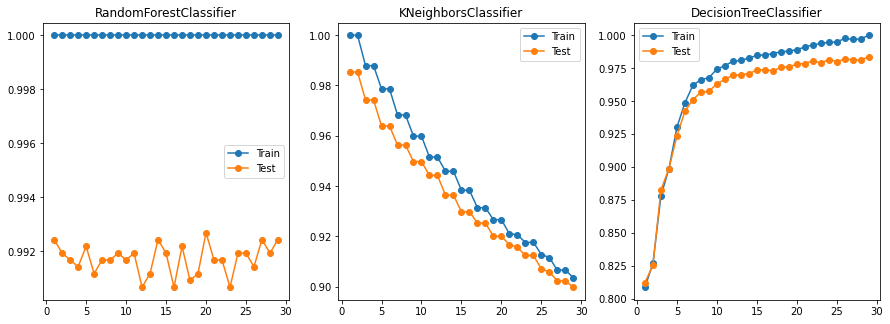

In [36]:
X_train_final = X_train_kBest.copy()
X_test_final = X_test_kBest.copy()

check_overfitting(X_train_final, y_resample, X_test_final, y_test , 30)

we find out that "random forest" results in overfitting problem.

# Model Selection

## Test models with hyperparameters and compare them with default hyperparameters

Using "grid search" package for hyperparameter tuning

The point of the grid that maximizes the average value in cross-validation, is the optimal combination of values for the hyperparameters.

We do not use random search because it tests only a randomly selected subset of these points. Besides, the smaller this subset, the faster but less accurate the optimization.

In [37]:
model_params = {
    "knn": {
        "model": KNeighborsClassifier(),
        "params": {
            "n_neighbors": [
                1,
                3,
                5,
                7,
                15,
                17,
                100,
            ],  # odd number, how many neighbors we use to decide the best classfication result
            "p": [1, 2, 5],  # power parameter for the Minkowski metric
        },
    },
    "random_forest": {
        "model": RandomForestClassifier(),
        "params": {
            "n_estimators": [
                1,
                5,
                7,
                10,
                44,
                50,
                60,
            ],  # the number of trees in the forest
        },
    },
    "logistic_regression": {
        "model": LogisticRegression(solver="liblinear"),
        "params": {
            "C": [
                1,
                5,
                9,
                10,
            ],  # inverse of regularization strength; must be a positive float
        },
    },
    "decision_tree": {
        "model": DecisionTreeClassifier(),
        "params": {
            "max_depth": [10,20,30,40]
        }       
    }
}

In [38]:
scores = []

for model_name, mp in model_params.items():
    clf = GridSearchCV(mp["model"], mp["params"], cv=5, return_train_score=False)
    clf.fit(X_final, y_final)
    scores.append(
        {
            "model": model_name,
            "best_score": clf.best_score_,
            "best_params": clf.best_params_,
        }
    )

df = pd.DataFrame(scores, columns=["model", "best_score", "best_params"])
df

,model,best_score,best_params
0,knn,0.977802,"{'n_neighbors': 1, 'p': 1}"
1,random_forest,0.992651,{'n_estimators': 44}
2,logistic_regression,0.855059,{'C': 10}
3,decision_tree,0.981817,{'max_depth': 40}


RandomForestClassifier: train accurancy- 1.00 and test accruancy- 0.99
LogisticRegression: train accurancy- 0.86 and test accruancy- 0.87
KNeighborsClassifier: train accurancy- 1.00 and test accruancy- 0.99
DecisionTreeClassifier: train accurancy- 1.00 and test accruancy- 0.98


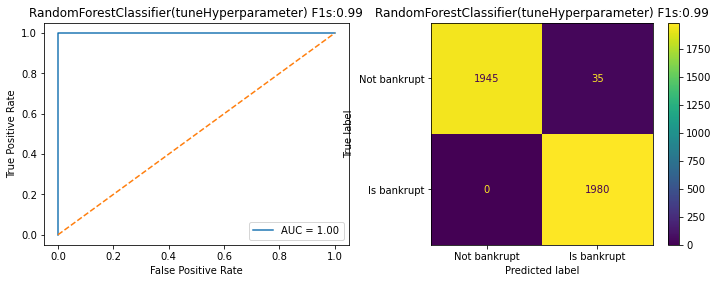

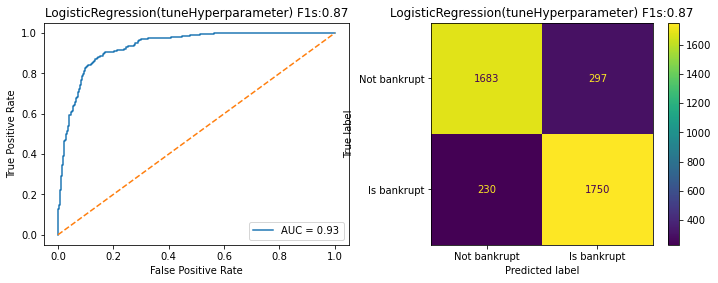

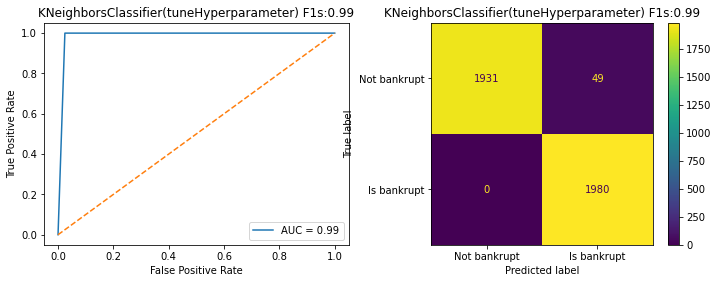

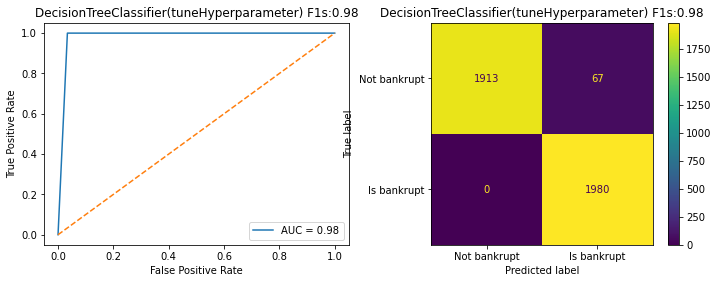

In [39]:
# display optimal solutions
optimal_models = [RandomForestClassifier(n_estimators=10), LogisticRegression(solver="liblinear", C=1), KNeighborsClassifier(n_neighbors=1, p=1), DecisionTreeClassifier(max_depth=40)]
models = optimal_models
testModels(X_final, y_final, C_OPT, True)

# Model Evaluation

In [40]:
models_f1Score

,RandomForestClassifier,LogisticRegression,KNeighborsClassifier,DecisionTreeClassifier
Original,0.655293,0.491298,0.519838,0.653229
UnderSampling,0.855854,0.560202,0.560505,0.78744
OverSampling,0.992929,0.60671,0.952164,0.985603
SMOTE,0.978276,0.594698,0.91193,0.950498
tuneHyperparameter,0.991161,0.866881,0.987624,0.983076
TargetHighCorr,0.993182,0.870923,0.959784,0.983329
remove5VIF with targetHighCorr,0.990908,0.838085,0.957499,0.982065
ModelReduceFeature,0.990656,0.370935,0.943763,0.983076
kBestMutualInfo,0.992171,0.866881,0.963842,0.98257


In [42]:
models_accurracy

,RandomForestClassifier,LogisticRegression,KNeighborsClassifier,DecisionTreeClassifier
Original,0.969697,0.965787,0.967253,0.95259
UnderSampling,0.856061,0.560606,0.560606,0.787879
OverSampling,0.992929,0.613889,0.952273,0.985606
SMOTE,0.978283,0.601768,0.912374,0.950505
tuneHyperparameter,0.991162,0.866919,0.987626,0.983081
TargetHighCorr,0.993182,0.87096,0.959848,0.983333
remove5VIF with targetHighCorr,0.990909,0.838131,0.957576,0.982071
ModelReduceFeature,0.990657,0.407828,0.943939,0.983081
kBestMutualInfo,0.992172,0.866919,0.963889,0.982576


<Figure size 1000x600 with 0 Axes>

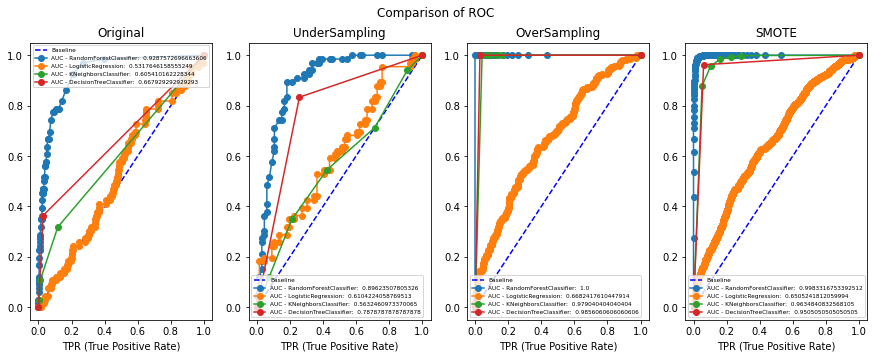

In [45]:
# plot the combined AUC curves - resample basis
plt.figure(figsize=(10, 6))

# plot figure
fig, sub_figs = plt.subplots(1, 4, sharex=False, figsize=(15, 5), dpi=72)
fig.suptitle("Comparison of ROC")

count = 0
for data_name, mds in auc_rocs.items():
    if data_name not in [C_ORIGINAL, C_UNDERSAMPLING, C_OVERSAMPLING, C_SMOTE]:
        continue
    sub_figs[count].set_title(data_name)
    # plot the baseline model, AUC of 0.5
    sub_figs[count].plot([0, 1], [0, 1], color="blue", linestyle="--", label="Baseline")

    sub_figs[count].set_xlabel("FPR (False Positive Rate)", size=10)
    sub_figs[count].set_xlabel("TPR (True Positive Rate)", size=10) 
    for i, item in enumerate(mds):
        sub_figs[count].plot(item['fpr'], item['tpr'], "-o", label=f"AUC - {item['model_name']}:  {item['auc']}")
    sub_figs[count].legend(fontsize="xx-small")
    count+=1
plt.show()


# todo, final decision? decision tree
From the aboved tables, we can see the best accuracy can be calculated by using oversamping with random forest classfication, and logistic regression is least fit to our data.

However, considering the problem of overfitting, we decide to choose KNN as the best method in our project.

Moreover, with some features selected, we are able to improve the prediction accuracy in random forest classification and KNN classification significantly.

# Conclusion

After resolving the imbalanced dataset with imblearn-oversampling, we train classification models to find best and efficient solution under different dataset processed by serveral ways of feature selection. Then we choose dataset processed by MutualInfo. In addition, we check wheter there exsits overfitting problem by comparing different models, and it results that only RandomFroest has overfitting problem. After hyperparameter, our best solution is {feature resample - oversampling, feature selection - MutualInfo, model - K-Nearest-Neighbors}.